In [ ]:
! git clone "https://github.com/jpn2bz-blip/Project1_G9_DS4002.git"

Cloning into 'Project1_G9_DS4002'...
remote: Enumerating objects: 169, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (166/166), done.
remote: Total 169 (delta 95), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (169/169), 231.73 KiB | 11.59 MiB/s, done.
Resolving deltas: 100% (95/95), done.


In [ ]:
#Removing data directory so updates can be had
!rm -rf Project1_G9_DS4002


In [ ]:
import pandas as pd
import faiss
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sentence_transformers import SentenceTransformer
import chromadb
from chromadb.utils import embedding_functions
from sentence_transformers import SentenceTransformer

In [ ]:
# File paths
files = {
    "back_to_black": "/content/Project1_G9_DS4002/DATA/back_to_black_lyrics.csv",
    "reputation": "/content/Project1_G9_DS4002/DATA/reputation_lyrics.csv",
    "sabrina": "/content/Project1_G9_DS4002/DATA/Man's_Best_Friend_lyrics.csv"
}

In [ ]:
dfs = []
for name, path in files.items():
    df = pd.read_csv(path)

    # ✅ Ensure lyrics column
    if "lyrics" not in df.columns:
        if "Lyrics" in df.columns:
            df["lyrics"] = df["Lyrics"].apply(clean_lyrics)
        else:
            raise ValueError(f"CSV {path} does not contain a 'lyrics' column.")

    # ✅ Ensure song column exists (sometimes named differently)
    if "song" not in df.columns:
        if "Song" in df.columns:
            df["song"] = df["Song"]
        elif "title" in df.columns:
            df["song"] = df["title"]
        else:
            df["song"] = "Unknown"  # fallback if missing

    df["album"] = name
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)


In [ ]:
print("Loading embedding model...")
model = SentenceTransformer("all-MiniLM-L6-v2")  # ~384 dimensions

print("Embedding lyrics...")
embeddings = model.encode(
    data["lyrics"].astype(str).tolist(),
    convert_to_numpy=True,
    show_progress_bar=True
)

Loading embedding model...
Embedding lyrics...


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
dim = embeddings.shape[1]
index = faiss.IndexFlatL2(dim)
index.add(embeddings)

print(f"FAISS index built with {index.ntotal} lyrics.")

FAISS index built with 34 lyrics.


In [ ]:
def search_lyrics(query: str, top_k: int = 3):
    q_emb = model.encode([query], convert_to_numpy=True)
    D, I = index.search(q_emb, top_k * 5)  # fetch more candidates, then re-rank

    results = []
    for idx, dist in zip(I[0], D[0]):
        if idx == -1:
            continue
        row = data.iloc[idx]
        snippet = row["lyrics"][:200] + ("..." if len(row["lyrics"]) > 200 else "")

        # Boost if query words appear directly in the lyrics
        lyric_text = row["lyrics"].lower()
        boost = 0.0
        if all(word in lyric_text for word in query.lower().split()):
            boost = -0.5

        results.append({
            "artist": row.get("artist", "Unknown"),
            "album": row["album"],
            "song": row.get("song", "Unknown"),
            "lyric": snippet,
            "distance": float(dist + boost)
        })

    # Re-rank after boosting
    results = sorted(results, key=lambda x: x["distance"])[:top_k]

    # Add ranks
    for i, r in enumerate(results, start=1):
        r["rank"] = i

    return results

    return results


In [ ]:
def plot_matches(results, query):
    """
    Plot the similarity scores for search results.
    """
    # Extract values
    ranks = [r["rank"] for r in results]
    distances = [r["distance"] for r in results]
    labels = [f"{r['artist']} - {r['song']}" for r in results]

    # Create bar chart
    plt.figure(figsize=(8, 7))
    bars = plt.bar(ranks, distances, tick_label=labels)

    # Annotate distances on top of bars
    for bar, dist in zip(bars, distances):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f"{dist:.3f}", ha="center", va="bottom", fontsize=10)

    plt.title(f" Match Results for Query: \"{query}\"")
    plt.xlabel("Song (Artist - Title)")
    plt.ylabel("Distance (lower = better)")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()


🔎 Query: I said i have no idea

Rank 1:
Artist: Amy Winehouse
Album: back_to_black
Song: Rehab
Lyrics snippet: They tried to make me go to rehab, but I said, "No, no, no" Yes, I've been black, but when I come back, you'll know, know, know I ain't got the time and if my daddy thinks I'm fine He's tried to make ...
Distance: 0.9441

Rank 2:
Artist: Sabrina Carpenter
Album: sabrina
Song: When Did You Get Hot?
Lyrics snippet: So long, untouched Bone-dry, not a plant can grow 'Bout time I get Back on the horse to the rodeo Now I'm at the prospect convention My friends walk in your friends' direction Said, "Sabrina, don't yo...
Distance: 1.5183

Rank 3:
Artist: Sabrina Carpenter
Album: sabrina
Song: Manchild
Lyrics snippet: Oh boy You said your phone was broken, just forgot to charge it Whole outfit you're wearing, God, I hope it's ironic Did you just say you're finished? Didn't know we started It's all just so familiar,...
Distance: 1.6196


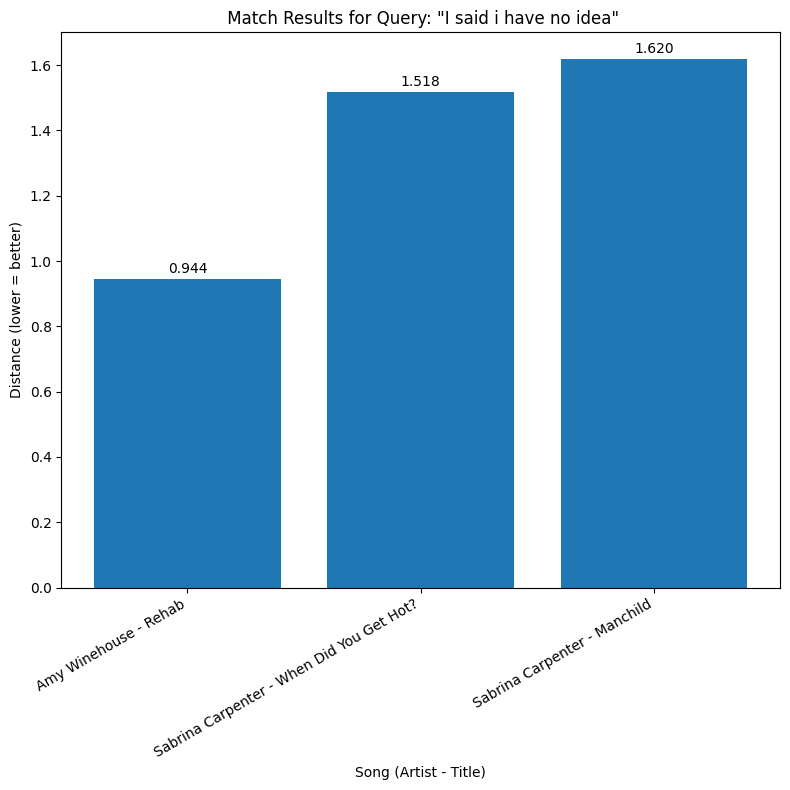

In [ ]:
query = "I said i have no idea"
results = search_lyrics(query, top_k=3)

print("\n🔎 Query:", query)
for r in results:
    print(f"\nRank {r['rank']}:")
    print(f"Artist: {r['artist']}")
    print(f"Album: {r['album']}")
    print(f"Song: {r['song']}")   # ✅ Added song title
    print(f"Lyrics snippet: {r['lyric']}")
    print(f"Distance: {r['distance']:.4f}")
# Plot results
plot_matches(results, query)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Example: lyrics dataset (already split by rows = snippet/song/lyrics chunk)
texts = df["lyrics"]      # your lyric snippets
artists = df["artist"]    # labels for Model A
albums = df["album"]      # labels for Model B

# Convert lyrics to TF-IDF vectors
vectorizer = TfidfVectorizer(
    stop_words="english",
    max_features=5000,    # limit features for speed
    ngram_range=(1,2)     # unigrams + bigrams for context
)
X = vectorizer.fit_transform(texts)


In [ ]:
print("✅ Data loaded with shape:", data.shape)
print("\nColumns:", data.columns.tolist())
print("\nArtist counts:\n", data["artist"].value_counts())
print("\nAlbum counts:\n", data["album"].value_counts())
print("\nSample rows:\n", data.head())

✅ Data loaded with shape: (34, 4)

Columns: ['artist', 'album', 'song', 'lyrics']

Artist counts:
 artist
Sabrina Carpenter    12
Amy Winehouse        11
Taylor Swift         11
Name: count, dtype: int64

Album counts:
 album
sabrina          12
back_to_black    11
reputation       11
Name: count, dtype: int64

Sample rows:
           artist          album                  song  \
0  Amy Winehouse  back_to_black                 Rehab   
1  Amy Winehouse  back_to_black  You Know I’m No Good   
2  Amy Winehouse  back_to_black        Me & Mr. Jones   
3  Amy Winehouse  back_to_black          Just Friends   
4  Amy Winehouse  back_to_black         Back to Black   

                                              lyrics  
0  They tried to make me go to rehab, but I said,...  
1  Meet you downstairs in the bar and hurt Your r...  
2  Nobody stands in between me and my man It's me...  
3  When will we get the time to be just friends? ...  
4  He left no time to regret Kept his dick wet Wi...  


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# ---------------- TF-IDF ----------------
tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
X = tfidf.fit_transform(data["lyrics"])

# ---------------- Model A: Artist ----------------
X_train, X_test, y_train, y_test = train_test_split(
    X, data["artist"],
    test_size=0.2, random_state=42, stratify=data["artist"]
)

artist_clf = LogisticRegression(max_iter=2000)
artist_clf.fit(X_train, y_train)

print("🎤 Artist Classification Report")
print(classification_report(y_test, artist_clf.predict(X_test)))

# ---------------- Model B: Album ----------------
X_train, X_test, y_train, y_test = train_test_split(
    X, data["album"],
    test_size=0.2, random_state=42, stratify=data["album"]
)

album_clf = LogisticRegression(max_iter=2000)
album_clf.fit(X_train, y_train)

print("\n💿 Album Classification Report")
print(classification_report(y_test, album_clf.predict(X_test)))

# ---------------- Model C: Song ----------------
song_clf = LogisticRegression(max_iter=1000)
song_clf.fit(X, data["song"])


🎤 Artist Classification Report
                   precision    recall  f1-score   support

    Amy Winehouse       0.00      0.00      0.00         2
Sabrina Carpenter       0.33      0.33      0.33         3
     Taylor Swift       1.00      0.50      0.67         2

         accuracy                           0.29         7
        macro avg       0.44      0.28      0.33         7
     weighted avg       0.43      0.29      0.33         7


💿 Album Classification Report
               precision    recall  f1-score   support

back_to_black       0.00      0.00      0.00         2
   reputation       0.67      1.00      0.80         2
      sabrina       0.00      0.00      0.00         3

     accuracy                           0.29         7
    macro avg       0.22      0.33      0.27         7
 weighted avg       0.19      0.29      0.23         7



LogisticRegression(max_iter=1000)

In [ ]:
def predict_snippet(snippet):
    X_new = tfidf.transform([snippet])

    # Artist
    artist_pred = artist_clf.predict(X_new)[0]
    artist_probs = artist_clf.predict_proba(X_new)[0]

    # Album
    album_pred = album_clf.predict(X_new)[0]
    album_probs = album_clf.predict_proba(X_new)[0]

    # Song
    song_pred = song_clf.predict(X_new)[0]
    song_probs = song_clf.predict_proba(X_new)[0]

    return {
        "artist": artist_pred,
        "artist_probs": dict(zip(artist_clf.classes_, artist_probs)),
        "album": album_pred,
        "album_probs": dict(zip(album_clf.classes_, album_probs)),
        "song": song_pred,
        "song_probs": dict(zip(song_clf.classes_, song_probs))
    }



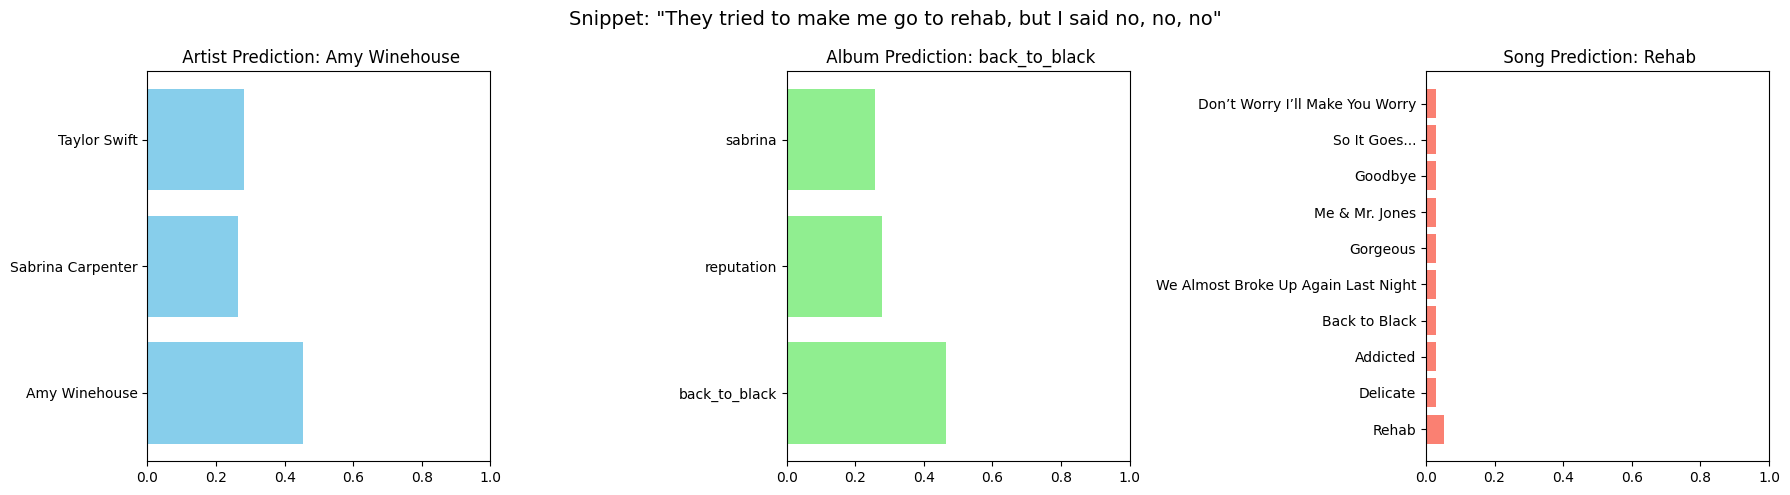

In [ ]:
def plot_prediction(results, snippet):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Artist
    axes[0].barh(list(results["artist_probs"].keys()),
                 list(results["artist_probs"].values()),
                 color="skyblue")
    axes[0].set_xlim(0, 1)
    axes[0].set_title(f" Artist Prediction: {results['artist']}")

    # Album
    axes[1].barh(list(results["album_probs"].keys()),
                 list(results["album_probs"].values()),
                 color="lightgreen")
    axes[1].set_xlim(0, 1)
    axes[1].set_title(f" Album Prediction: {results['album']}")

    # Song
    # Take top 10 songs for readability
    song_probs_sorted = sorted(results["song_probs"].items(), key=lambda x: x[1], reverse=True)[:10]
    axes[2].barh([s[0] for s in song_probs_sorted],
                 [s[1] for s in song_probs_sorted],
                 color="salmon")
    axes[2].set_xlim(0, 1)
    axes[2].set_title(f" Song Prediction: {results['song']}")

    plt.suptitle(f'Snippet: "{snippet}"', fontsize=14)
    plt.tight_layout()
    plt.show()


# ---------------- Example Usage ----------------
snippet = "They tried to make me go to rehab, but I said no, no, no"
results = predict_snippet(snippet)
plot_prediction(results, snippet)